In [1]:
import pandas as pd
import os
import numpy as np 
import glob
import matplotlib.pyplot as plt

In [2]:
path = os.getcwd() +'\\CLA'
# os.listdir(path)
# list to store files
file_names = []
# Iterate directory
for file in os.listdir(path):
    # check only text files
    if file.endswith('.csv'):
        file_names.append(file[3:-4])
print(file_names)

['SubjectA1601083StLRHand', 'SubjectB1510193StLRHand', 'SubjectB1510203StLRHand', 'SubjectB1512153StLRHand', 'SubjectC1511263StLRHand', 'SubjectC1512163StLRHand', 'SubjectC1512233StLRHand', 'SubjectD1511253StLRHand', 'SubjectE1512253StLRHand', 'SubjectE1601193StLRHand', 'SubjectE1601223StLRHand', 'SubjectF1509163StLRHand', 'SubjectF1509173StLRHand', 'SubjectF1509283StLRHand']


In [3]:
path = os.getcwd() +'\\CLA\\*.csv'
file_direction = glob.glob(path)

In [4]:
data = {}
columns = ['Control','Fp1','Fp2','F3','F4','C3','C4','P3',
           'P4','O1','O2','A1','A2','F7','F8','T3','T4','T5','T6','Fz','Cz','Pz','X5']
for i in range(len(file_direction)):
    data[file_names[i]] = pd.read_csv(file_direction[i],header=0,names=columns)

In [5]:
data.keys()

dict_keys(['SubjectA1601083StLRHand', 'SubjectB1510193StLRHand', 'SubjectB1510203StLRHand', 'SubjectB1512153StLRHand', 'SubjectC1511263StLRHand', 'SubjectC1512163StLRHand', 'SubjectC1512233StLRHand', 'SubjectD1511253StLRHand', 'SubjectE1512253StLRHand', 'SubjectE1601193StLRHand', 'SubjectE1601223StLRHand', 'SubjectF1509163StLRHand', 'SubjectF1509173StLRHand', 'SubjectF1509283StLRHand'])

In [6]:
data['SubjectA1601083StLRHand'].columns

Index(['Control', 'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
       'A1', 'A2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'X5'],
      dtype='object')

## Visualization of the data

In [7]:
vis_control = data['SubjectA1601083StLRHand']['Control']
vis_c3 = data['SubjectA1601083StLRHand']['C3']
vis_x5 = data['SubjectA1601083StLRHand']['X5']

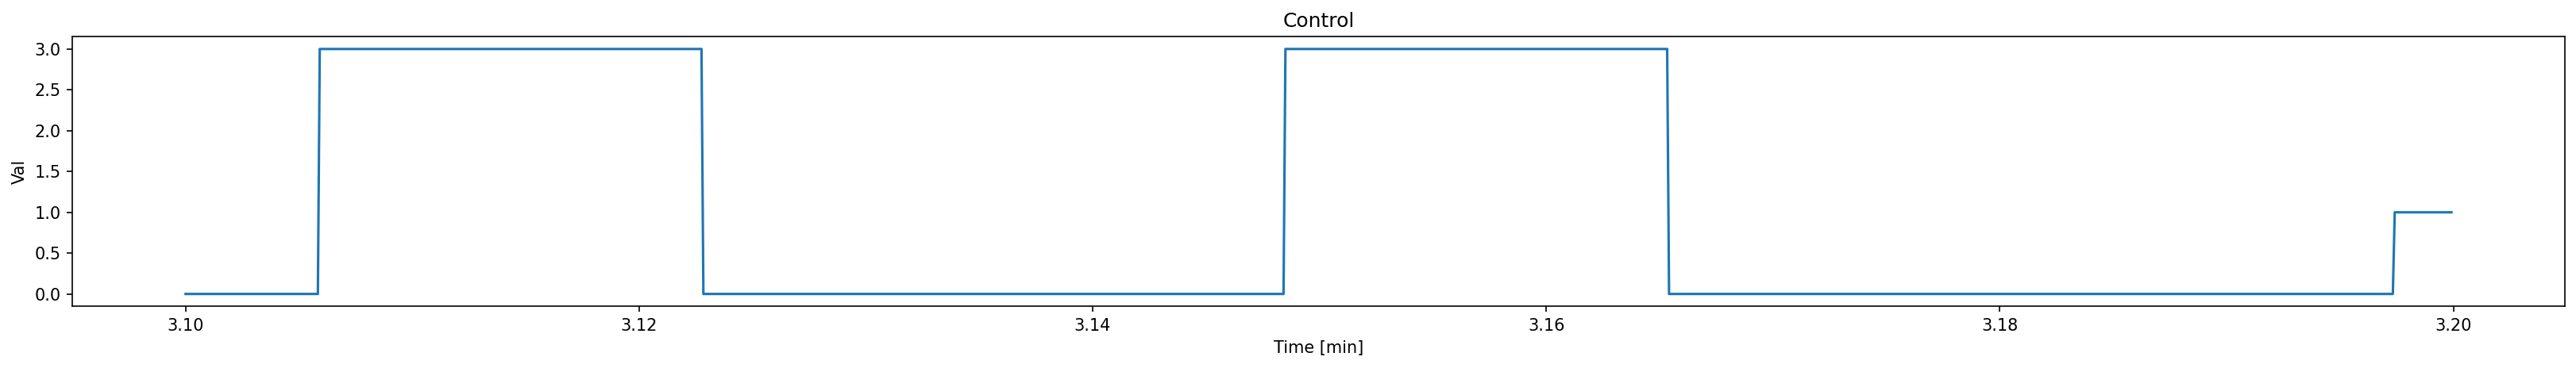

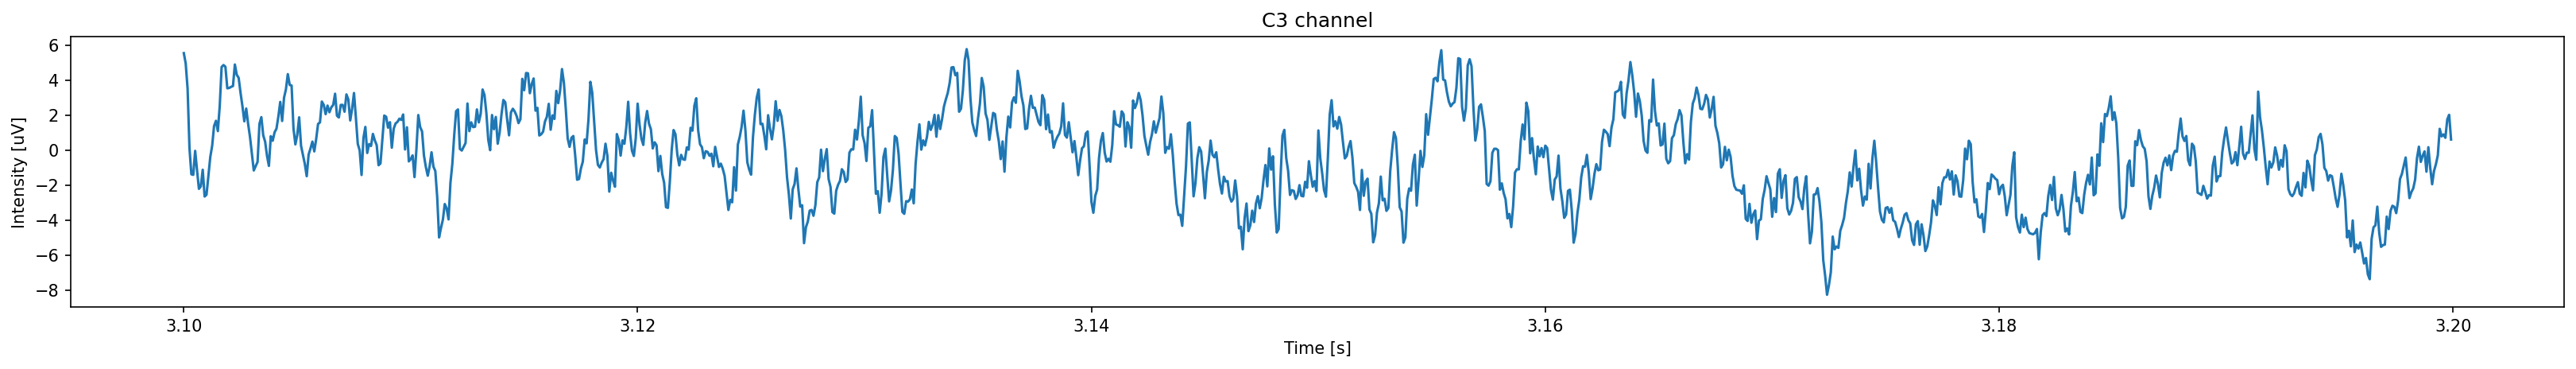

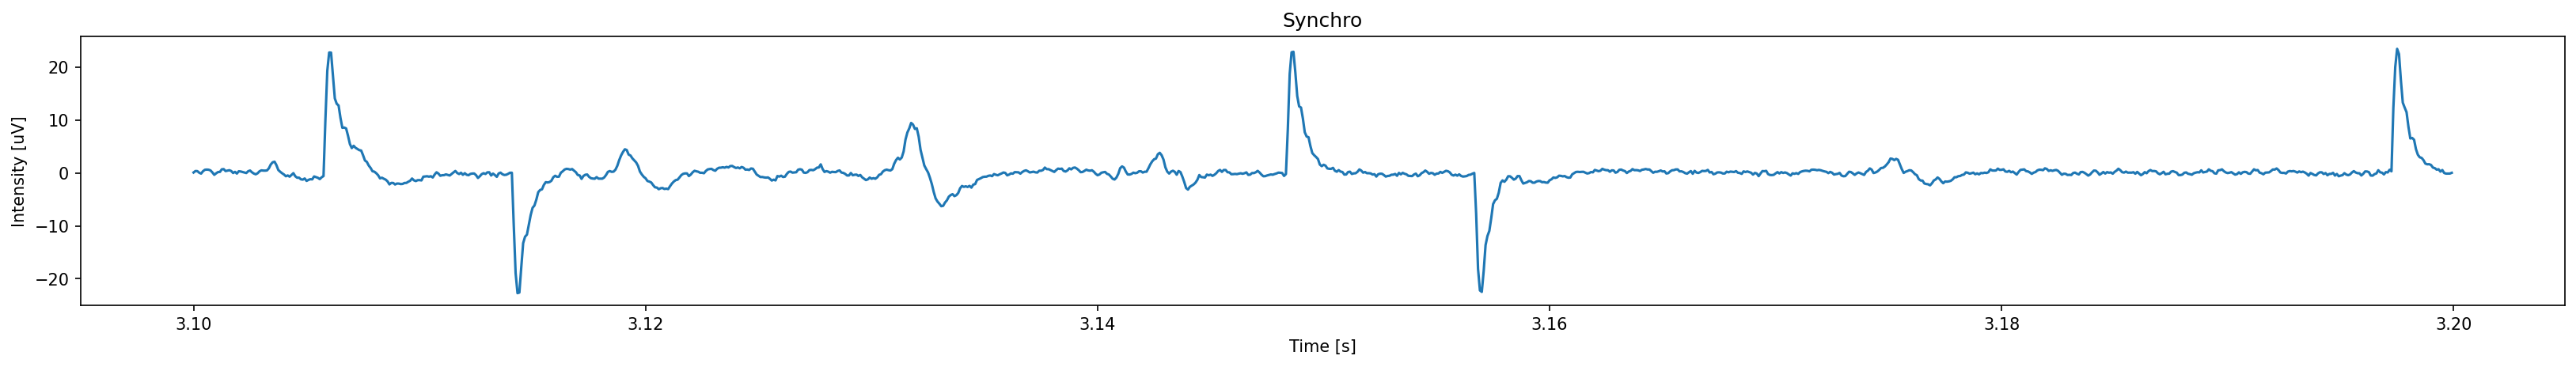

In [9]:
sf = 200 #1/s
t = np.arange(0,len(vis_control)/200,1/200)
plt.rcParams['figure.figsize'] = (27, 3)
plt.rcParams['figure.dpi'] = (150)
minutes = lambda s: round(s*60*sf)
t_i = 3.1
# t_f = round(len(vis_control)/(200*60))
t_f = 3.2
plt.plot(t[minutes(t_i):minutes(t_f)]/60,vis_control[minutes(t_i):minutes(t_f)])
plt.xlabel('Time [min]')
plt.ylabel('Val')
plt.title('Control')
plt.show()
plt.plot(t[minutes(t_i):minutes(t_f)]/60,vis_c3[minutes(t_i):minutes(t_f)])
plt.xlabel('Time [s]')
plt.ylabel('Intensity [uV]')
plt.title('C3 channel')
plt.show()
plt.plot(t[minutes(t_i):minutes(t_f)]/60,vis_x5[minutes(t_i):minutes(t_f)])
plt.xlabel('Time [s]')
plt.title('Synchro')
plt.ylabel('Intensity [uV]')
plt.show()

In [9]:
# Useful function to get the correct order of appearance of the sign change (activation/deactivation of the signal)
def gen_series(arr,odd=True):
    n = len(arr)
    if odd:
        odds = []
        for i in range(0,n):
            if i %2 !=0:
                odds.append(i)
        return odds
    else:
        even = []
        for i in range(0,n):
            if i%2 ==0:
                even.append(i)
        return even

In [10]:
def segmentator(file,s1,s2,s3):
    """
    This function recieves a complete patient session and segments it on 3 parts in order to eliminate the resting between 
    the paradigms
    file (Pandas DF) := DataFrame of the complete session 
    si (tuple) := Tuple of the initial and final time markers for each segment, in minutes
    Observed values (approx) s1 = (3,20), s2 = (21,36) , s3 = (40,55)
    """
    sf = 200 #Hz
    minutes = lambda s: round(s*60*sf)
    segments = {}
    segments['s1'] = file.iloc[minutes(s1[0]):minutes(s1[1])]
    segments['s2'] = file.iloc[minutes(s2[0]):minutes(s2[1])]
    segments['s3'] = file.iloc[minutes(s3[0]):minutes(s3[1])]
    return segments

In [43]:
def traces(segment,ctrl_val, t0_s, t1_s):
    """
    This function recieves a DF segment and a Control Value to get and obtains a time-windowed DF around the 
    stimulii according to the t0 and t1 values
    segment (Pandas DF) := Session segment, obtained from the sementator function
    ctr_val (int) := Control "marker" code to filter.
    t0_s (float) := +/- seconds for the starting point of the window according to the moment the stimulli started
    t1_S (float) _= +/- seconds for the ending point of the window according to the moment the stimulli ended
    """
    ctrl = segment['Control'].copy().values    #Get the control vector of the segment
    ctrl[np.where(ctrl!=ctrl_val)] =0    #Filter the other states 
    sign = np.sign(ctrl)
    sign_change = ((np.roll(sign,1)-sign) !=0).astype(int)    #Get the sign change in the control vector
    sign_change[0] = 0    #Fix the sign change in the first element
    start_indexes = np.where(sign_change==1)[0][gen_series(np.where(sign_change==1)[0],odd=False)]    #Set the indexes where stimulii started
    end_indexes = np.where(sign_change==1)[0][gen_series(np.where(sign_change==1)[0],odd=True)]
    traces = []
    seconds = lambda x: int(x*200)    #Transform the seconds to number of sampligs for a 200Hz samplig rate
    t0 = seconds(t0_s)
    t1 = seconds(t1_s)
    for i in range(len(start_indexes)):
        traces.append(segment.iloc[start_indexes[i]+t0:end_indexes[i]+t1])    #Add the windowed DF to a list
    return (traces,ctrl_val)    #Return the list of windowed DF and its corresponding label

def dict_list_appender(traces,df_dict):
    """
    This function recieves a tuple of traces and Control Values and updates a Final dictionary for the 
    segmented-traced and classified data. 
    traces (tuple) := Tuple containing the list of traced windowed-DFs and it's corresponding label
    df_dict (dictionary) := Dictionary where the data will be stored
    """
    for trace in traces[0]:    #Cycle arround the obtained traces
        for key in df_dict.keys():    #Cycle through the dictionary keys, they must match
            if key == 'Control':
                df_dict[key].append(traces[1])    # The Control label is defined
            else:
                df_dict[key].append(np.array(trace[key].values))    #Each channel is stored as an array
    return 

In [44]:
df_dict = {'Control':[], 'Fp1':[], 'Fp2':[], 'F3':[], 'F4':[], 'C3':[], 'C4':[], 'P3':[], 'P4':[], 'O1':[], 'O2':[],
       'A1':[], 'A2':[], 'F7':[], 'F8':[], 'T3':[], 'T4':[], 'T5':[], 'T6':[], 'Fz':[], 'Cz':[], 'Pz':[], 'X5':[]}

In [45]:
# dict_list_appender(traces(data['SubjectA1601083StLRHand'].iloc[minutes(3):minutes(20)],1,50,5),df_dict)
dict_list_appender(traces(segmentator(data['SubjectA1601083StLRHand'],(3,20),(21,36),(40,55))['s1'], 1,-0.5,1),df_dict)

In [46]:
test_df = pd.DataFrame.from_dict(df_dict)

In [47]:
test_df

,Control,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,...,F7,F8,T3,T4,T5,T6,Fz,Cz,Pz,X5
0,1,"[1.13, 0.65, -0.87, 1.41, 5.91, 3.97, 4.38, 2....","[0.12, -4.88, -3.75, -4.47, -1.97, -0.55, 0.66...","[-2.42, -3.45, -2.0, -1.26, -0.21, 0.02, -0.68...","[4.12, 4.83, 5.19, 4.03, 5.67, 5.29, 4.44, 5.2...","[-2.38, -2.77, -2.57, -2.6, -0.88, -0.37, -1.7...","[1.06, 2.48, 2.38, 2.07, 1.67, 1.43, 1.08, 1.9...","[-1.26, -2.11, -3.06, -3.79, -2.04, -1.43, -1....","[2.93, 4.02, 3.67, 2.88, 3.03, 2.6, 1.01, 1.57...","[0.84, -1.38, -3.6, -5.15, -1.38, 0.62, -0.27,...",...,"[-4.55, -7.92, -7.33, -5.86, -2.01, 1.02, -3.0...","[13.85, 14.79, 13.14, 12.64, 13.42, 13.21, 13....","[-1.51, -3.5, -2.8, -2.04, 0.29, 0.92, -1.86, ...","[5.65, 6.78, 4.58, 3.54, 4.88, 4.68, 4.12, 6.3...","[5.11, 2.7, -0.77, -0.7, 1.98, 3.27, 1.65, 3.4...","[4.65, 5.34, 3.72, 2.35, 3.47, 4.09, 2.78, 4.0...","[-0.15, 0.11, 2.21, 2.5, 4.34, 3.17, 3.49, 4.4...","[-2.97, -1.03, 0.04, -0.36, 0.9, -0.75, -1.73,...","[-0.71, -0.04, -1.08, -1.77, -0.97, -1.86, -2....","[0.26, 0.69, 0.42, 0.34, -0.06, -0.13, 0.5, 0...."
1,1,"[5.83, 7.24, 7.88, 5.76, 6.58, 5.4, 7.69, 6.77...","[-12.91, -12.83, -13.7, -13.58, -10.9, -9.57, ...","[4.58, 4.47, 5.38, 4.7, 4.6, 4.02, 4.44, 4.15,...","[-4.96, -4.75, -4.84, -4.46, -3.39, -4.58, -3....","[3.43, 2.49, 4.99, 4.68, 4.33, 3.9, 3.18, 2.97...","[-2.6, -1.72, -4.1, -4.16, -3.48, -4.11, -3.28...","[1.76, 1.71, 4.3, 4.45, 4.48, 4.33, 3.43, 2.88...","[-1.91, 0.04, -0.58, -0.75, -2.06, -3.8, -4.48...","[-0.87, 2.13, 3.45, 2.86, 1.51, -0.53, -3.9, -...",...,"[3.83, 0.23, 2.29, 1.8, 4.34, 5.82, 6.04, 5.83...","[-2.14, -4.31, -5.51, -3.77, -1.84, -3.75, -3....","[0.48, -1.49, 1.63, 0.15, 1.56, 3.64, 3.63, 4....","[-6.3, -6.45, -7.63, -8.91, -8.25, -8.51, -7.9...","[-2.99, -0.8, 4.21, 5.17, 5.35, 6.12, 4.77, 3....","[-6.86, -4.72, -5.49, -7.14, -6.78, -8.18, -8....","[-0.18, -0.51, 1.03, 0.83, 0.61, -0.49, 0.03, ...","[-0.08, -0.26, 1.22, 1.86, 0.67, -1.23, -1.26,...","[0.75, 1.68, 2.08, 2.17, 0.54, -0.29, -1.23, -...","[-0.43, 0.1, 0.36, 0.47, -0.15, -0.27, -0.64, ..."
2,1,"[-5.46, -3.83, -4.2, -11.03, -8.18, -9.85, -10...","[10.39, 10.61, 8.55, 6.25, 6.8, 13.61, 9.97, 1...","[-0.02, 0.71, 2.46, 3.95, 5.33, 3.63, 2.44, 2....","[3.59, 4.03, 3.04, 1.71, 0.74, 4.19, 3.9, 4.83...","[-1.45, -1.32, 0.02, 1.95, 2.93, 0.18, -0.48, ...","[0.01, 1.31, -0.2, -0.35, -1.9, 0.27, 2.17, 0....","[-0.41, -1.23, -1.23, 0.99, 0.61, -1.68, -2.16...","[-1.06, -0.96, -1.65, -1.35, -0.76, 0.91, 1.59...","[0.44, -2.55, -3.04, -4.9, -5.6, -5.61, -4.84,...",...,"[-10.5, -9.38, -10.25, -8.64, -5.3, -7.13, -6....","[-1.53, 0.41, -1.18, -1.43, -1.01, 2.37, 0.09,...","[-11.11, -10.76, -10.67, -7.06, -4.4, -6.89, -...","[-5.08, -4.02, -5.47, -4.53, -3.4, 0.62, -0.71...","[-6.35, -6.71, -5.34, -4.23, -5.14, -5.9, -7.2...","[-2.97, -2.69, -3.94, -4.04, -3.83, -1.39, -1....","[1.58, 2.92, 3.3, 2.84, 1.89, 3.23, 3.47, 3.27...","[1.86, 2.36, 2.87, 1.64, 2.77, 3.33, 3.38, 1.5...","[1.64, 0.99, -0.08, 1.17, 1.0, 0.59, 1.09, -0....","[0.22, -0.0, -0.46, 0.07, 0.04, -0.09, -0.16, ..."
3,1,"[3.92, 7.35, 4.16, 3.71, 0.74, -2.02, -1.94, -...","[-5.63, -5.89, -5.2, -6.88, -5.45, -7.16, -5.1...","[3.77, 3.02, 3.98, 1.77, 1.46, 0.83, -0.46, 0....","[-7.57, -7.18, -7.79, -8.24, -6.24, -6.3, -5.4...","[1.97, 1.25, 2.22, 0.48, -1.03, -1.43, -2.36, ...","[-1.86, -1.71, -2.06, -1.38, 0.18, 1.88, 1.97,...","[1.62, 0.83, 1.29, -0.32, -0.48, -1.26, -1.51,...","[-4.36, -6.16, -6.55, -5.12, -1.93, -1.7, -1.1...","[0.5, -2.2, -2.46, -2.08, -0.87, -3.09, -4.01,...",...,"[-7.12, -8.51, -8.32, -12.49, -12.68, -13.11, ...","[-5.93, -5.5, -4.83, -5.66, -4.81, -4.76, -3.6...","[4.55, 2.11, 3.72, -1.94, -3.02, -3.42, -0.44,...","[-5.99, -6.2, -5.88, -4.04, -4.47, -3.38, -2.3...","[4.1, 1.88, 2.23, -0.37, -1.99, -3.3, -3.02, -...","[-5.19, -7.12, -6.71, -4.8, -3.8, -2.95, -2.3,...","[0.59, 0.67, -0.58, -2.33, -3.22, -4.9, -5.19,...","[-4.06, -4.3, -4.12, -4.44, -4.99, -3.63, -4.6...","[-2.75, -3.8, -4.58, -4.03, -1.83, -1.87, -2.5.

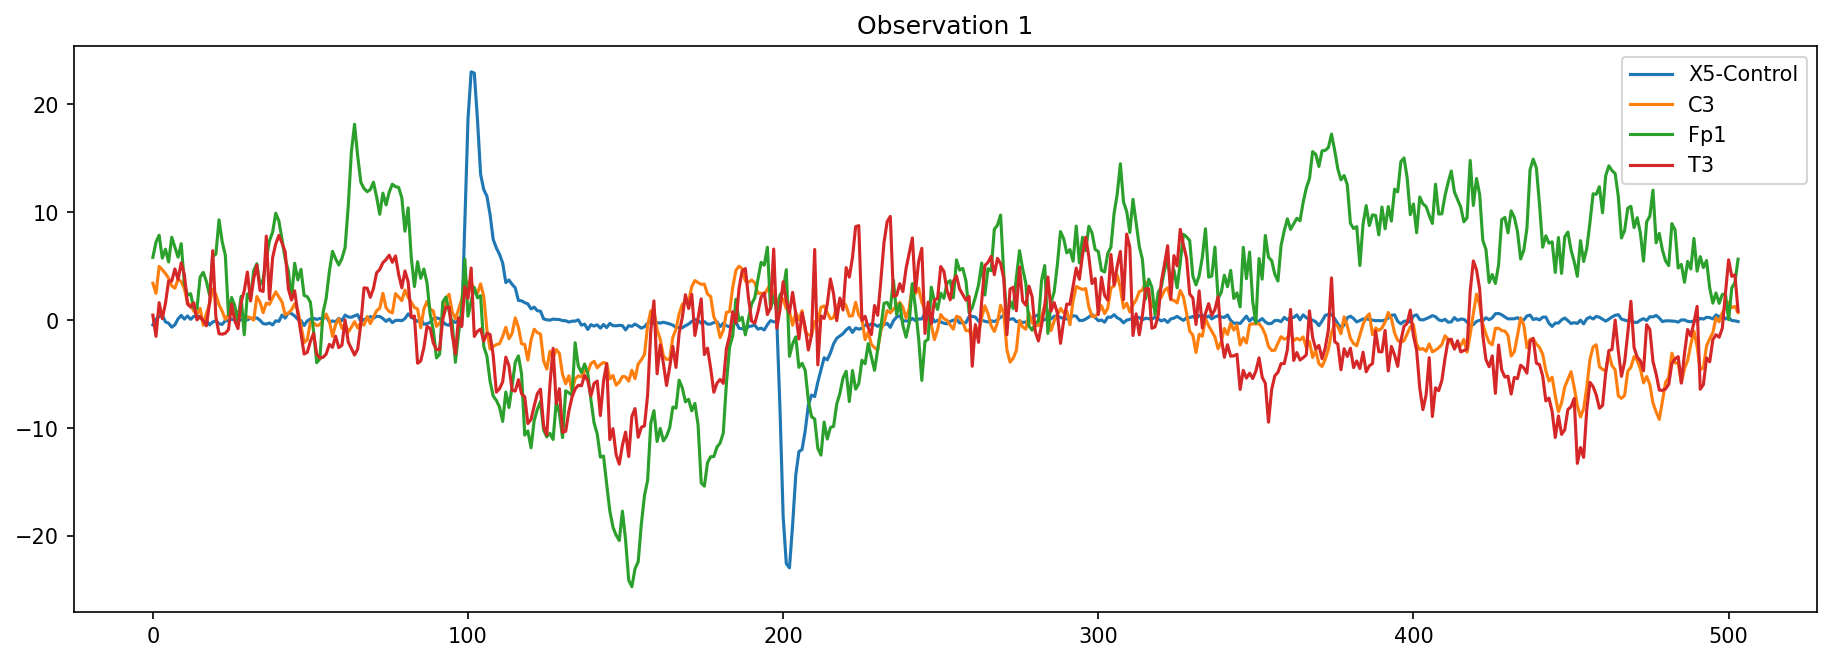

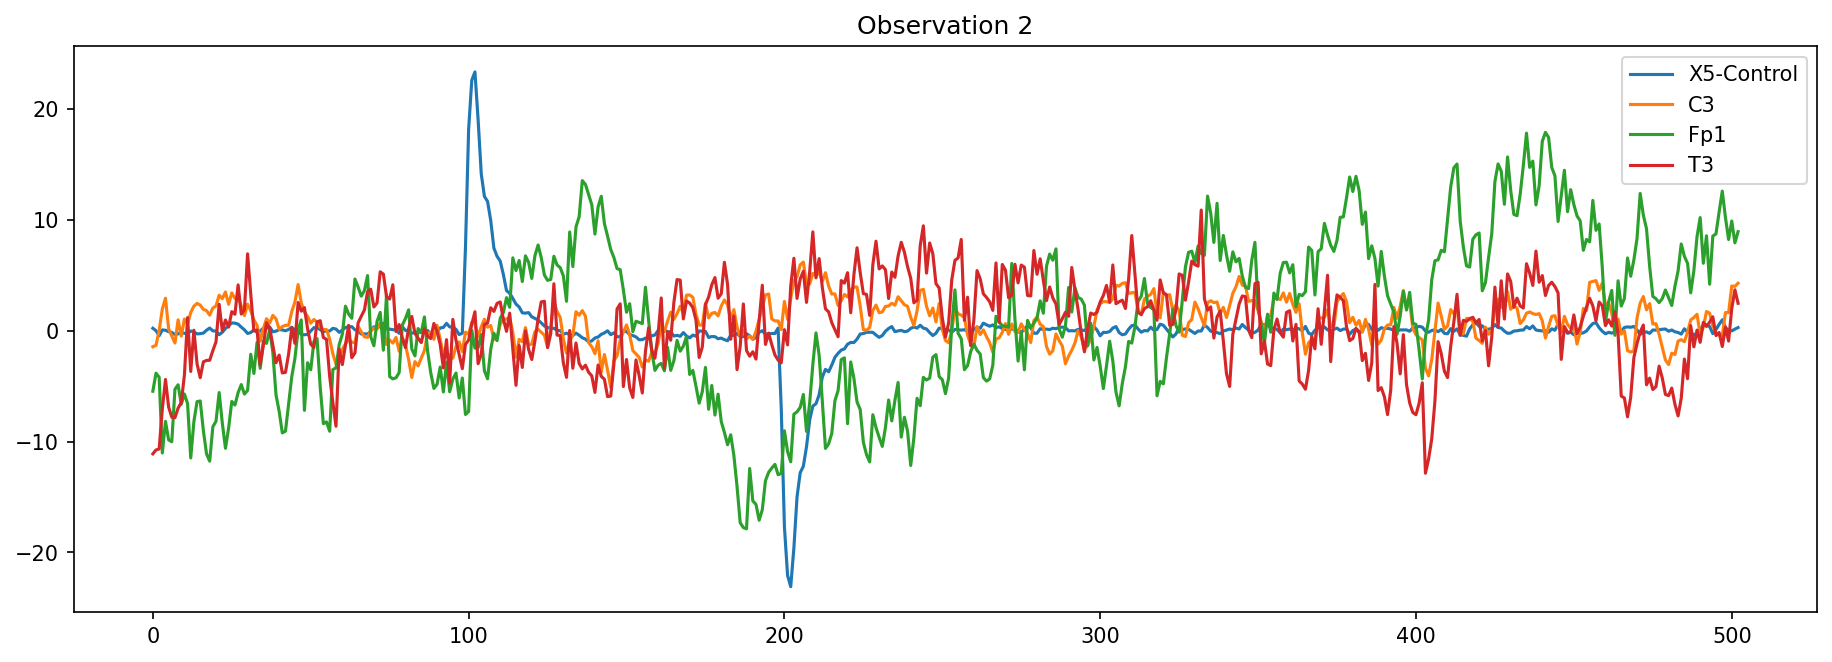

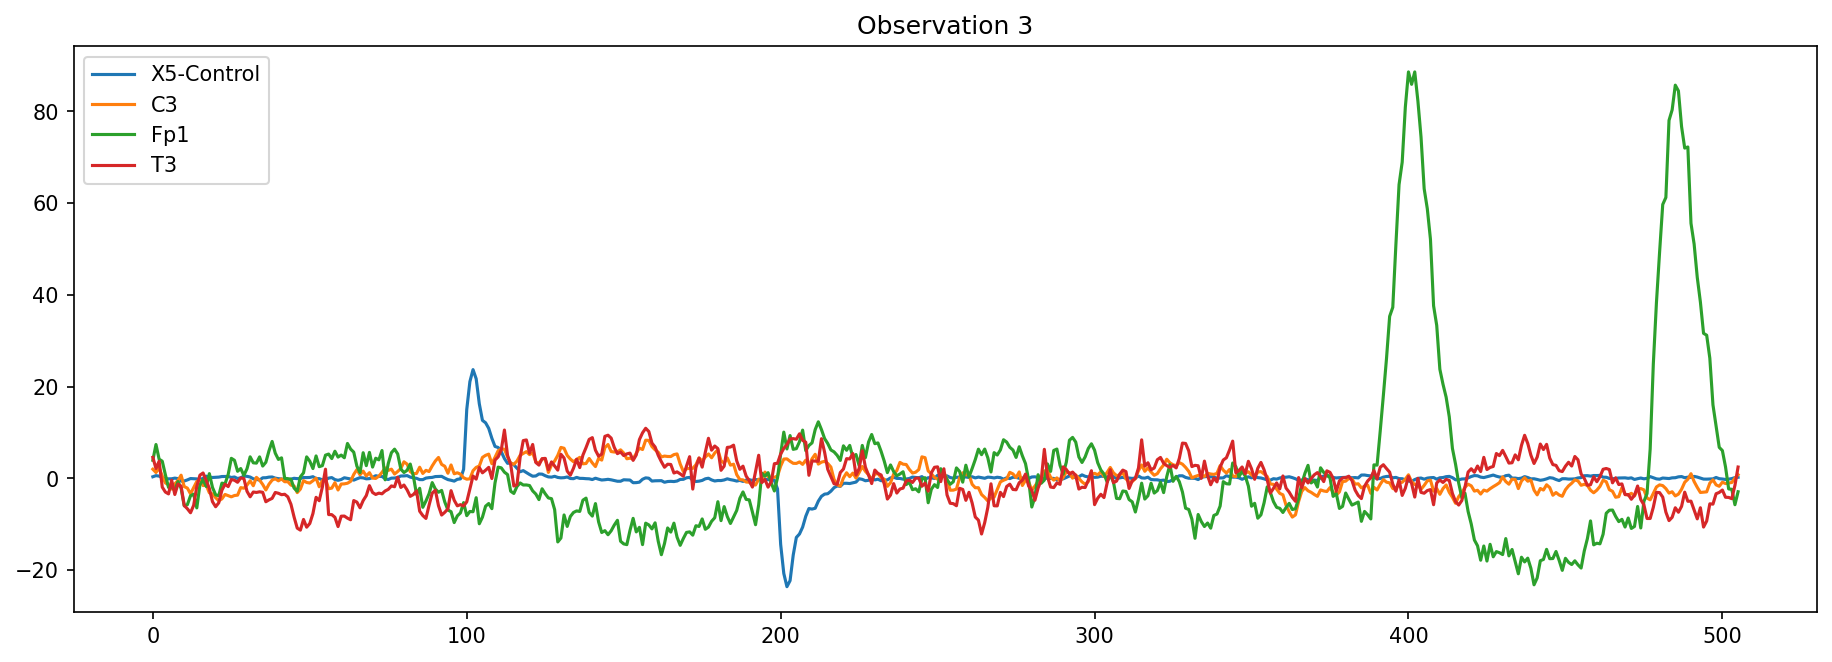

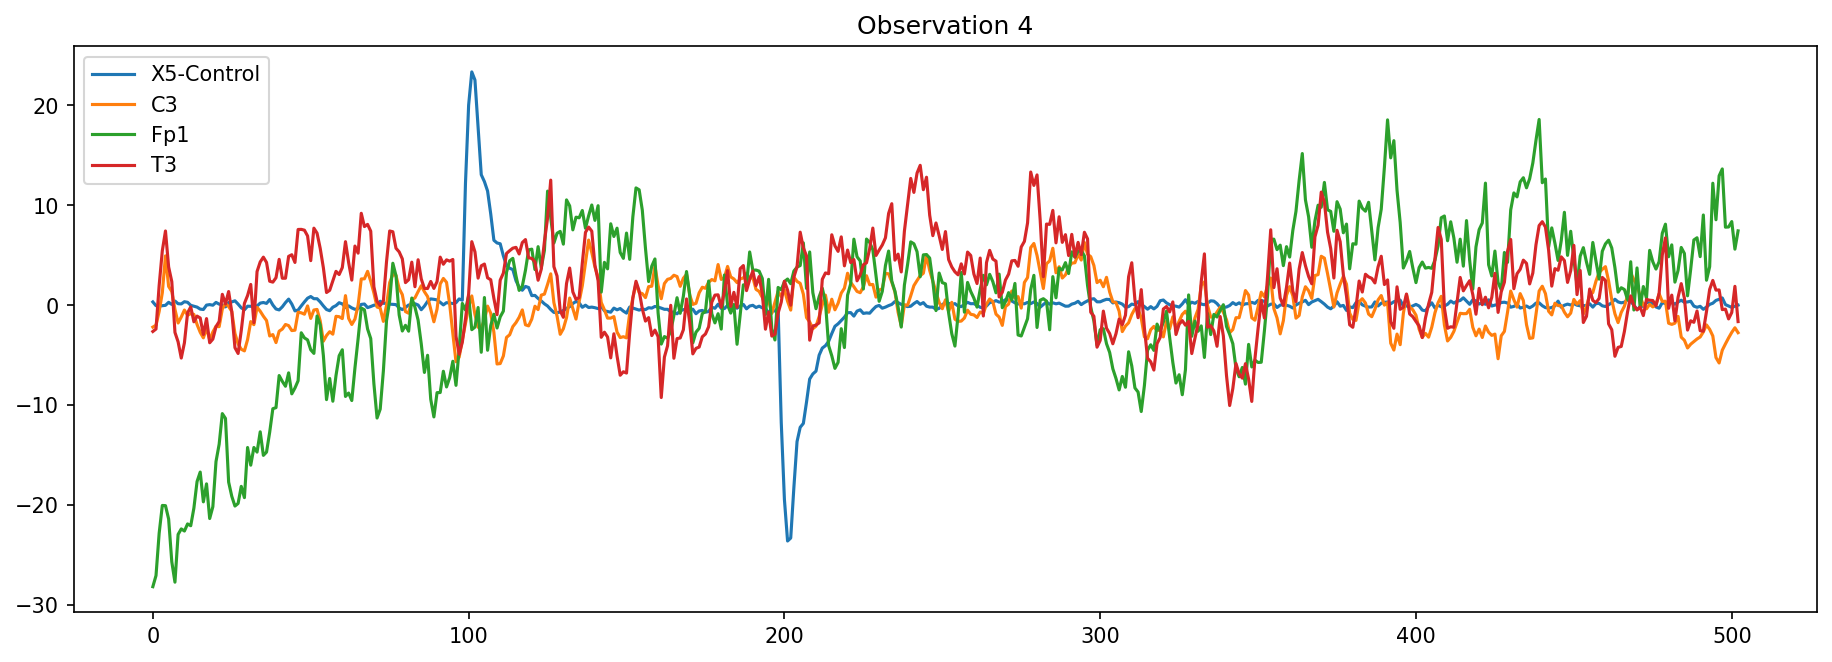

In [48]:
for i in range (1,5):
    plt.plot(test_df['X5'][i],label='X5-Control')
    plt.plot(test_df['C3'][i],label='C3')
    plt.plot(test_df['Fp1'][i],label='Fp1')
    plt.plot(test_df['T3'][i],label='T3')
    plt.title(f'Observation {i}')
    plt.legend()
    plt.show()

The functions needed for the data extraction and classification have been defined, now a class will be generated in order to do the whole process on all the files.

In [1]:
from data_extraction import EEGProcess

In [2]:
    datset = EEGProcess().extraction((2,22),(20,37),(38,59),-0.5,1.5, [1,2,3])

  7%|█████▉                                                                             | 1/14 [00:00<00:07,  1.82it/s]

Splitted state, ommiting trace
Splitted state, ommiting trace


 14%|███████████▊                                                                       | 2/14 [00:01<00:06,  1.77it/s]

Splitted state, ommiting trace
Splitted state, ommiting trace


 43%|███████████████████████████████████▌                                               | 6/14 [00:03<00:04,  1.83it/s]

Splitted state, ommiting trace


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [00:07<00:00,  1.80it/s]

Splitted state, ommiting trace
Splitted state, ommiting trace


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.79it/s]


<AxesSubplot:>

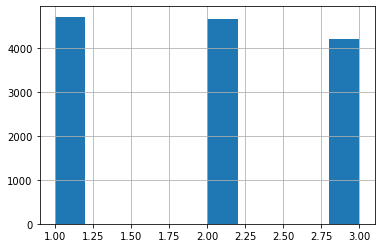

In [3]:
datset.Control.hist()

In [4]:
datset

,Control,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,...,F7,F8,T3,T4,T5,T6,Fz,Cz,Pz,X5
0,1,"[1.13, 0.65, -0.87, 1.41, 5.91, 3.97, 4.38, 2....","[0.12, -4.88, -3.75, -4.47, -1.97, -0.55, 0.66...","[-2.42, -3.45, -2.0, -1.26, -0.21, 0.02, -0.68...","[4.12, 4.83, 5.19, 4.03, 5.67, 5.29, 4.44, 5.2...","[-2.38, -2.77, -2.57, -2.6, -0.88, -0.37, -1.7...","[1.06, 2.48, 2.38, 2.07, 1.67, 1.43, 1.08, 1.9...","[-1.26, -2.11, -3.06, -3.79, -2.04, -1.43, -1....","[2.93, 4.02, 3.67, 2.88, 3.03, 2.6, 1.01, 1.57...","[0.84, -1.38, -3.6, -5.15, -1.38, 0.62, -0.27,...",...,"[-4.55, -7.92, -7.33, -5.86, -2.01, 1.02, -3.0...","[13.85, 14.79, 13.14, 12.64, 13.42, 13.21, 13....","[-1.51, -3.5, -2.8, -2.04, 0.29, 0.92, -1.86, ...","[5.65, 6.78, 4.58, 3.54, 4.88, 4.68, 4.12, 6.3...","[5.11, 2.7, -0.77, -0.7, 1.98, 3.27, 1.65, 3.4...","[4.65, 5.34, 3.72, 2.35, 3.47, 4.09, 2.78, 4.0...","[-0.15, 0.11, 2.21, 2.5, 4.34, 3.17, 3.49, 4.4...","[-2.97, -1.03, 0.04, -0.36, 0.9, -0.75, -1.73,...","[-0.71, -0.04, -1.08, -1.77, -0.97, -1.86, -2....","[0.26, 0.69, 0.42, 0.34, -0.06, -0.13, 0.5, 0...."
1,1,"[5.83, 7.24, 7.88, 5.76, 6.58, 5.4, 7.69, 6.77...","[-12.91, -12.83, -13.7, -13.58, -10.9, -9.57, ...","[4.58, 4.47, 5.38, 4.7, 4.6, 4.02, 4.44, 4.15,...","[-4.96, -4.75, -4.84, -4.46, -3.39, -4.58, -3....","[3.43, 2.49, 4.99, 4.68, 4.33, 3.9, 3.18, 2.97...","[-2.6, -1.72, -4.1, -4.16, -3.48, -4.11, -3.28...","[1.76, 1.71, 4.3, 4.45, 4.48, 4.33, 3.43, 2.88...","[-1.91, 0.04, -0.58, -0.75, -2.06, -3.8, -4.48...","[-0.87, 2.13, 3.45, 2.86, 1.51, -0.53, -3.9, -...",...,"[3.83, 0.23, 2.29, 1.8, 4.34, 5.82, 6.04, 5.83...","[-2.14, -4.31, -5.51, -3.77, -1.84, -3.75, -3....","[0.48, -1.49, 1.63, 0.15, 1.56, 3.64, 3.63, 4....","[-6.3, -6.45, -7.63, -8.91, -8.25, -8.51, -7.9...","[-2.99, -0.8, 4.21, 5.17, 5.35, 6.12, 4.77, 3....","[-6.86, -4.72, -5.49, -7.14, -6.78, -8.18, -8....","[-0.18, -0.51, 1.03, 0.83, 0.61, -0.49, 0.03, ...","[-0.08, -0.26, 1.22, 1.86, 0.67, -1.23, -1.26,...","[0.75, 1.68, 2.08, 2.17, 0.54, -0.29, -1.23, -...","[-0.43, 0.1, 0.36, 0.47, -0.15, -0.27, -0.64, ..."
2,1,"[-5.46, -3.83, -4.2, -11.03, -8.18, -9.85, -10...","[10.39, 10.61, 8.55, 6.25, 6.8, 13.61, 9.97, 1...","[-0.02, 0.71, 2.46, 3.95, 5.33, 3.63, 2.44, 2....","[3.59, 4.03, 3.04, 1.71, 0.74, 4.19, 3.9, 4.83...","[-1.45, -1.32, 0.02, 1.95, 2.93, 0.18, -0.48, ...","[0.01, 1.31, -0.2, -0.35, -1.9, 0.27, 2.17, 0....","[-0.41, -1.23, -1.23, 0.99, 0.61, -1.68, -2.16...","[-1.06, -0.96, -1.65, -1.35, -0.76, 0.91, 1.59...","[0.44, -2.55, -3.04, -4.9, -5.6, -5.61, -4.84,...",...,"[-10.5, -9.38, -10.25, -8.64, -5.3, -7.13, -6....","[-1.53, 0.41, -1.18, -1.43, -1.01, 2.37, 0.09,...","[-11.11, -10.76, -10.67, -7.06, -4.4, -6.89, -...","[-5.08, -4.02, -5.47, -4.53, -3.4, 0.62, -0.71...","[-6.35, -6.71, -5.34, -4.23, -5.14, -5.9, -7.2...","[-2.97, -2.69, -3.94, -4.04, -3.83, -1.39, -1....","[1.58, 2.92, 3.3, 2.84, 1.89, 3.23, 3.47, 3.27...","[1.86, 2.36, 2.87, 1.64, 2.77, 3.33, 3.38, 1.5...","[1.64, 0.99, -0.08, 1.17, 1.0, 0.59, 1.09, -0....","[0.22, -0.0, -0.46, 0.07, 0.04, -0.09, -0.16, ..."
3,1,"[3.92, 7.35, 4.16, 3.71, 0.74, -2.02, -1.94, -...","[-5.63, -5.89, -5.2, -6.88, -5.45, -7.16, -5.1...","[3.77, 3.02, 3.98, 1.77, 1.46, 0.83, -0.46, 0....","[-7.57, -7.18, -7.79, -8.24, -6.24, -6.3, -5.4...","[1.97, 1.25, 2.22, 0.48, -1.03, -1.43, -2.36, ...","[-1.86, -1.71, -2.06, -1.38, 0.18, 1.88, 1.97,...","[1.62, 0.83, 1.29, -0.32, -0.48, -1.26, -1.51,...","[-4.36, -6.16, -6.55, -5.12, -1.93, -1.7, -1.1...","[0.5, -2.2, -2.46, -2.08, -0.87, -3.09, -4.01,...",...,"[-7.12, -8.51, -8.32, -12.49, -12.68, -13.11, ...","[-5.93, -5.5, -4.83, -5.66, -4.81, -4.76, -3.6...","[4.55, 2.11, 3.72, -1.94, -3.02, -3.42, -0.44,...","[-5.99, -6.2, -5.88, -4.04, -4.47, -3.38, -2.3...","[4.1, 1.88, 2.23, -0.37, -1.99, -3.3, -3.02, -...","[-5.19, -7.12, -6.71, -4.8, -3.8, -2.95, -2.3,...","[0.59, 0.67, -0.58, -2.33, -3.22, -4.9, -5.19,...","[-4.06, -4.3, -4.12, -4.44, -4.99, -3.63, -4.6...","[-2.75, -3.8, -4.58, -4.03, -1.83, -1.87, -2.5.

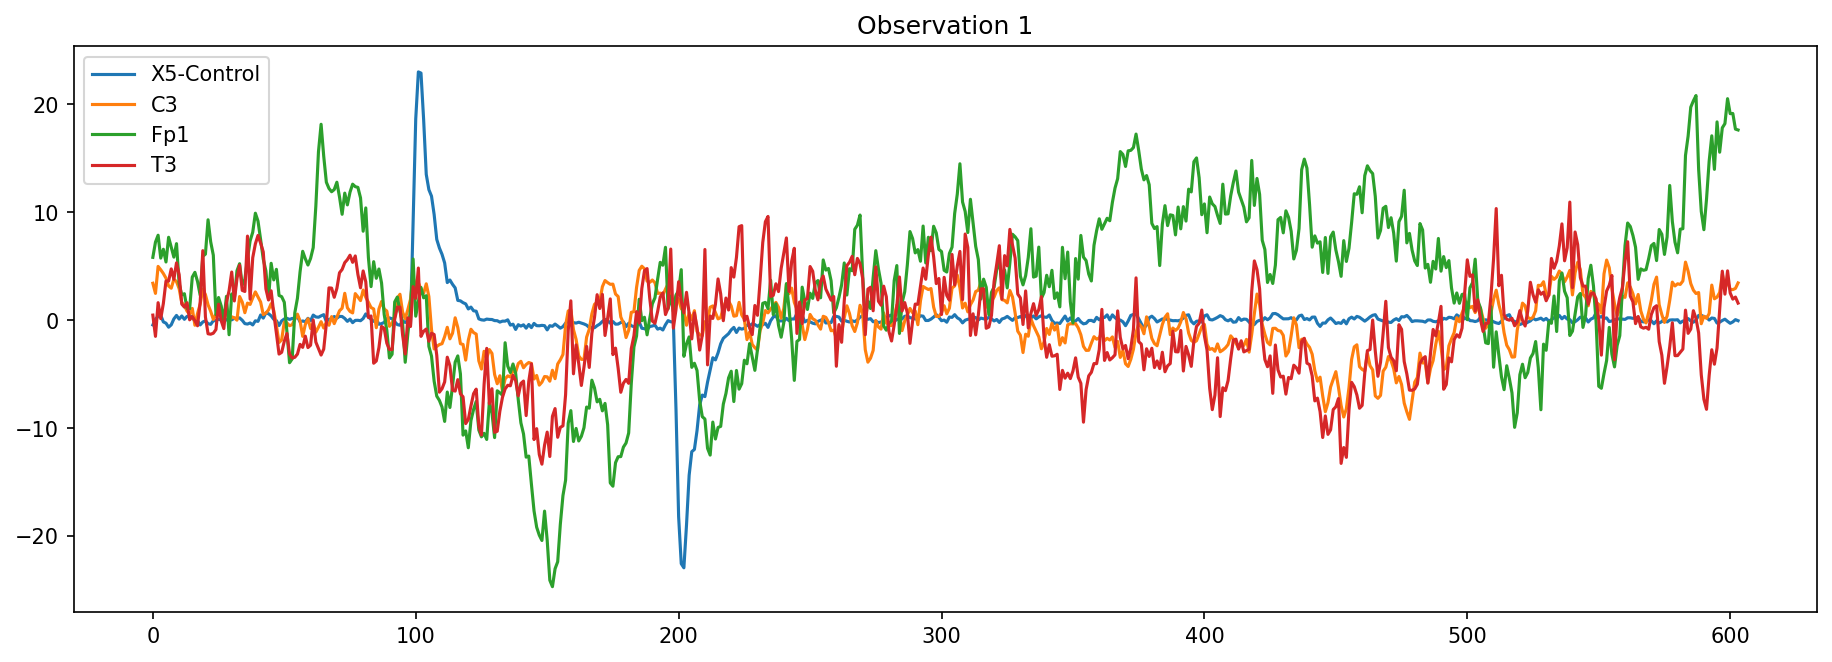

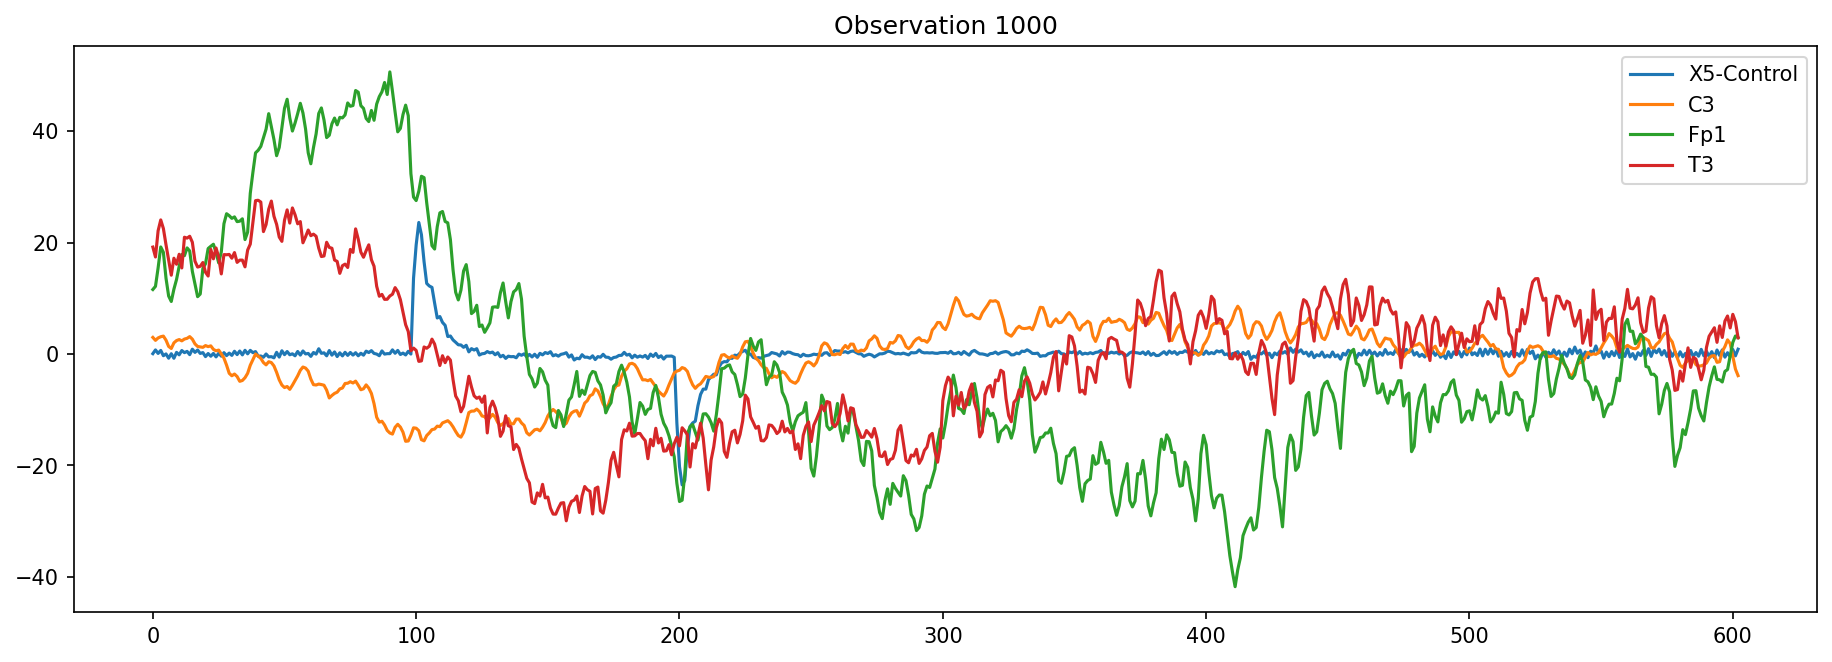

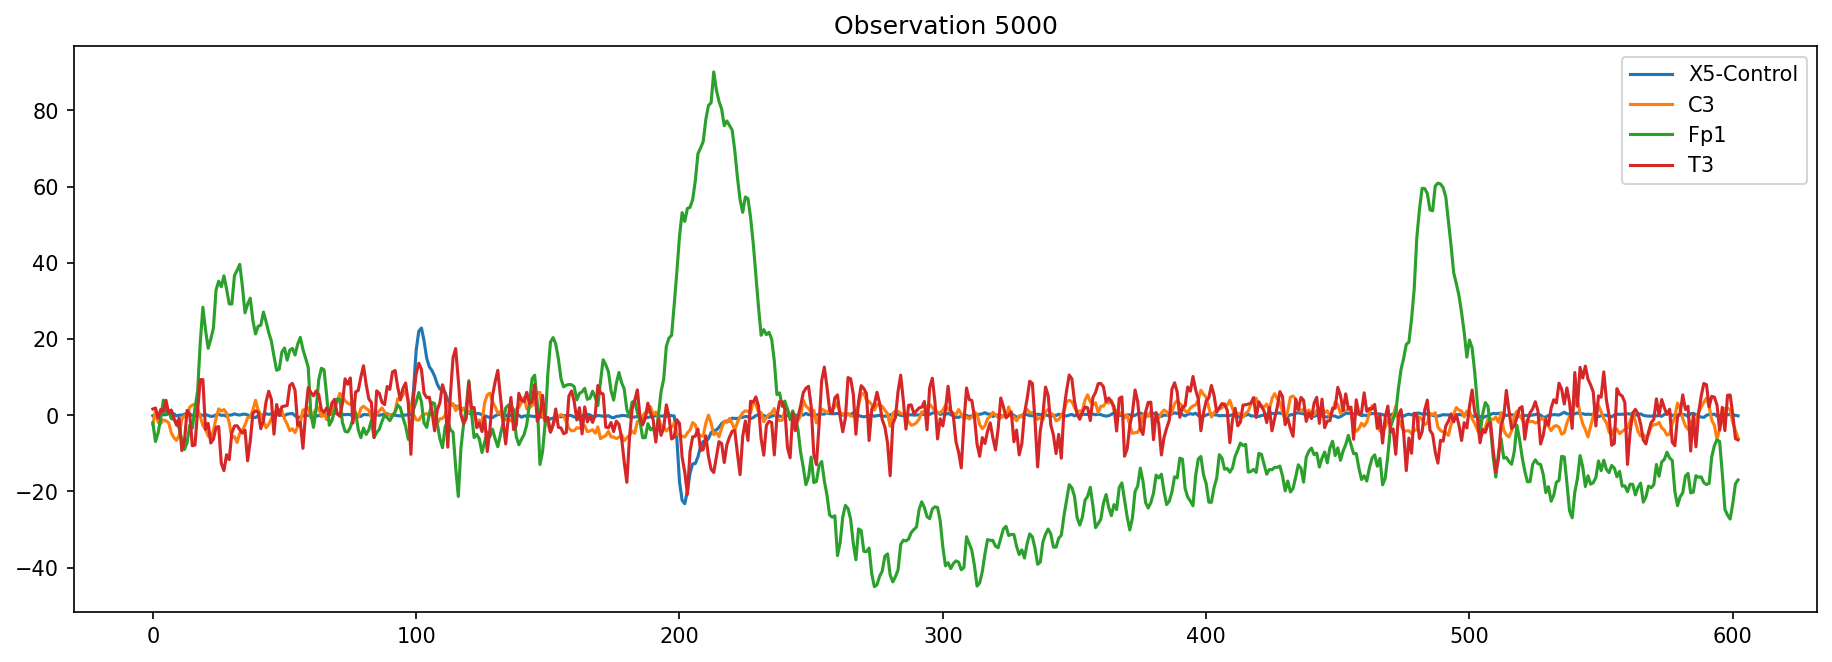

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['figure.dpi'] = (150)
for i in [1,1000,5000]:
    plt.plot(datset['X5'][i],label='X5-Control')
    plt.plot(datset['C3'][i],label='C3')
    plt.plot(datset['Fp1'][i],label='Fp1')
    plt.plot(datset['T3'][i],label='T3')
    plt.title(f'Observation {i}')
    plt.legend()
    plt.show()